# Notes

The following code is revised by [DINO](https://github.com/IDEA-Research/DINO/blob/main/inference_and_visualization.ipynb).

This notebook is for inference and visualizations.

In [1]:
import torch, json

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

# 0. Initialize and Load Pre-trained Models

In [2]:
model_config_path = "config/DINO_4scale_swin.py" # The path of the model config file
model_checkpoint_path = "logs/train/4SCALE-SWIN/checkpoint_best_regular.pth" # The path of the model checkpoint

In [3]:
args = SLConfig.fromfile(model_config_path)
args.device = 'cuda'
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

/home/howardkao/anaconda3/envs/cvpdlhw1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!


/home/howardkao/anaconda3/envs/cvpdlhw1/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020195/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
# Load dataset names
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# 1. Visualize Images from a Dataloader
## 1.1 Load Datasets

In [5]:
args.dataset_file = 'coco'
args.coco_path = "hw1_dataset/" # The path of dataset
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## 1.2 Get an Example and Visualize it

In [6]:
image, targets = dataset_val[1]

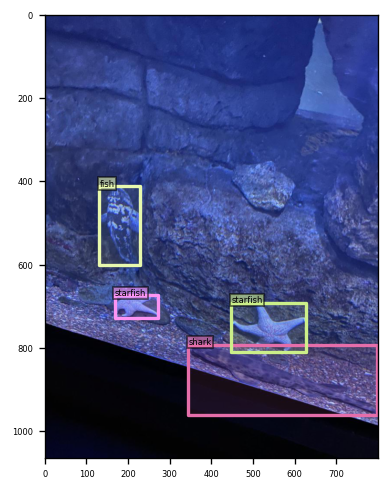

In [7]:
# Build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [8]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

/home/howardkao/anaconda3/envs/cvpdlhw1/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [9]:
thershold = 0.3 # Set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

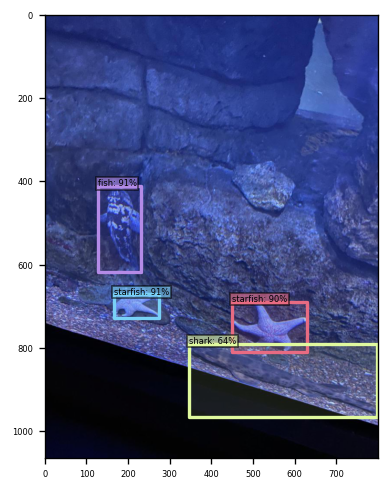

In [10]:
box_label = [id2name[int(item)] + f": {scr:.0%}" for item, scr in torch.stack([labels[select_mask], scores[select_mask]], dim=1)]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# 2. Visualize Test Images

In [11]:
from PIL import Image
import datasets.transforms as T

In [12]:
image = Image.open("./hw1_dataset/test/IMG_2570_jpeg_jpg.rf.ed40900b657a5b23d92cb2d296ad2dbc.jpg").convert("RGB") # Load image

In [13]:
# Transform images
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [14]:
# Predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

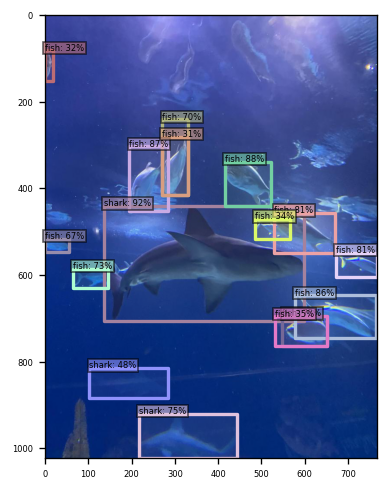

In [15]:
# Visualize outputs
thershold = 0.3 # Set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] + f": {scr:.0%}" for item, scr in torch.stack([labels[select_mask], scores[select_mask]], dim=1)]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# 3. Obtain output.json

In [16]:
import os

In [17]:
test_path = "hw1_dataset/test/"

output_dict = {}

In [18]:
for file in os.listdir(test_path):
    if file.lower().endswith(".jpg"):
        image = Image.open(os.path.join(test_path, file))

        # Transform images
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        image, _ = transform(image, None)
        
        # Predict images
        output = model.cuda()(image[None].cuda())
        output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

        scores = output['scores']
        labels = output['labels']
        boxes = output['boxes'] * torch.Tensor([image.shape[2], image.shape[1], image.shape[2], image.shape[1]]).cuda()

        pred_dict = {
            'boxes': boxes.cpu().numpy().tolist(),
            'labels': labels.cpu().numpy().tolist(),
            'scores': scores.cpu().numpy().tolist()
            }
        
        output_dict[f"{file}"] = pred_dict

In [19]:
with open("./output.json", "w") as output_file:
    json.dump(output_dict, output_file, indent=4)